In [4]:
import itertools
import math
import trueskill as t
import numpy as np


class TrueSkill_classifier:
    def __init__(self, starting_skill = 0, starting_var = (25/3), BETA = 25/6):
        #starting skill is defenitly 0, starting var has to be determined
        self.st_skill = starting_skill
        self.st_var = starting_var
        self.BETA = BETA
        self.learners = {}
        


    def win_probability(self,team1, team2):
        delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
        sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
        size = len(team1) + len(team2)
        denom = math.sqrt(size * (self.BETA * self.BETA) + sum_sigma)
        ts = t.global_env()
        return ts.cdf(delta_mu / denom)

    
    
    def fit(self,X,y, bias = False):
        #each instance of X is its own team
        #each feature is its own player
        
        #initialise features
        if self.learners == {}:
            for i in range(X.shape[1]):
                self.learners[i] = t.Rating(self.st_skill,self.st_var)
        
        if bias == True:
            
            self.learners['B'] = t.Rating(self.st_skill,self.st_var)
            
        #iterate over rows
        for i in range(X.shape[0]):
            
            #print(X[i,:])
            active_features = np.where(X[i,:] == 1)[0]
            
            
                
            #print(active_features)
            
            team_features = [self.learners[i] for i in active_features]
            
            if bias == True:
                team_features.append(self.learners['B'])
                
            dummy_features = [t.Rating(0,1/10000) for i in active_features]
            if y[i] == 1:
                #lower rank is better!!!
                (team_features,_) = t.rate([team_features,dummy_features],ranks=[0,1])
            else:
                (team_features,_) = t.rate([team_features,dummy_features],ranks=[1,0])
                
                            
            #print(team_features[-1])
            
            for i in range(len(active_features)):
                    #print(active_features[i])
                self.learners[active_features[i]] = team_features[i]
            
            #update learners
            if bias == True:
                self.learners['B'] = team_features[-1]
                #print(self.learners['B'])
            
        return None
            
    
    
    
    def predict_proba(self,X):
        #prediction is evaluation of instance against dummy team
        
        #predicted vector (probability that first wins)
        y_pred = []
        for i in range(X.shape[0]):
            active_features = np.where(X[i,:] == 1)[0]

            team_features = [self.learners[i] for i in active_features]
            dummy_features = [t.Rating(0,1/10000) for i in active_features]
            
            y_pred.append(self.win_probability(team_features,dummy_features))
        return y_pred
    
    def predict(self,X):
        y_proba = self.predict_proba(X)
        
        return([1 if i > 0.5 else 0 for i in y_proba])
        
        

In [5]:
learner = TrueSkill_classifier()

In [6]:
learner.fit(np.array([[0,1,1,1,0]]),[1])

In [7]:
learner.learners

{0: trueskill.Rating(mu=0.000, sigma=8.333),
 1: trueskill.Rating(mu=3.318, sigma=7.706),
 2: trueskill.Rating(mu=3.318, sigma=7.706),
 3: trueskill.Rating(mu=3.318, sigma=7.706),
 4: trueskill.Rating(mu=0.000, sigma=8.333)}

In [9]:
learner.predict_proba(np.array([[0,1,1,1,0]]))


[0.7232203947847158]

In [10]:
X = np.random.randint(2,size = (10,200))
y = np.random.randint(2,size = (1,200))[0]

In [11]:
people = []
for i in range(100):
    learner = TrueSkill_classifier()
    learner.fit(X,y)
    people.append(learner)

In [12]:
people[0].learners

{0: trueskill.Rating(mu=-0.675, sigma=8.259),
 1: trueskill.Rating(mu=0.368, sigma=8.261),
 2: trueskill.Rating(mu=-0.852, sigma=8.271),
 3: trueskill.Rating(mu=-0.505, sigma=8.274),
 4: trueskill.Rating(mu=0.322, sigma=8.212),
 5: trueskill.Rating(mu=1.255, sigma=8.273),
 6: trueskill.Rating(mu=-0.292, sigma=8.192),
 7: trueskill.Rating(mu=0.266, sigma=8.245),
 8: trueskill.Rating(mu=-1.135, sigma=8.264),
 9: trueskill.Rating(mu=-0.607, sigma=8.233),
 10: trueskill.Rating(mu=-1.288, sigma=8.215),
 11: trueskill.Rating(mu=-1.134, sigma=8.264),
 12: trueskill.Rating(mu=-0.439, sigma=8.236),
 13: trueskill.Rating(mu=-0.079, sigma=8.245),
 14: trueskill.Rating(mu=-1.680, sigma=8.275),
 15: trueskill.Rating(mu=-1.738, sigma=8.239),
 16: trueskill.Rating(mu=-1.041, sigma=8.196),
 17: trueskill.Rating(mu=-0.248, sigma=8.243),
 18: trueskill.Rating(mu=-0.164, sigma=8.232),
 19: trueskill.Rating(mu=-0.338, sigma=8.264),
 20: trueskill.Rating(mu=-0.193, sigma=8.297),
 21: trueskill.Rating(mu=-1

In [15]:
reprs = []
for i in people:
    rep = []
    for j in i.learners:
        rep.append(i.learners[j].mu)
    reprs.append(rep)

In [17]:
type(reprs)

list

In [18]:
reprs = np.array(reprs)

In [21]:
reprs.shape

(100, 200)

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2)

In [16]:
tsne = tsne.fit(reprs)

In [17]:
import matplotlib.pyplot as plt

plt.scatter(tsne.embedding_[:,0],tsne.embedding_[:,1])

In [18]:
tsne.embedding_[:,0]

array([2.7734215, 2.7734218, 2.7734213, 2.775295 , 2.7752957, 2.7734215,
       2.7752957, 2.7727587, 2.4088097, 2.420206 , 2.4210362, 2.4141579,
       2.4202065, 2.4209797, 2.4202058, 2.4209797, 2.4202056, 2.4032288,
       2.403228 , 2.402824 , 2.402916 , 2.4028244, 2.402824 , 2.4019146,
       2.4018972, 2.4018965, 2.967619 , 2.4028237, 2.401897 , 2.9831343,
       2.4023666, 2.0548644, 1.9817921, 2.0373547, 1.6472683, 3.079634 ,
       2.403513 , 2.4093955, 2.4088092, 2.4088094, 2.408809 , 2.4088087,
       2.5600307, 2.4018962, 2.4018972, 2.4019144, 2.4028232, 2.4028246,
       2.4028242, 2.4018967, 2.4028246, 2.3806052, 2.4028244, 2.402824 ,
       2.4029157, 2.4028249, 2.403229 , 2.4028244, 2.4032283, 2.4029162,
       2.7727582, 2.7727592, 2.7727587, 2.7752957, 2.7733374, 2.7733366,
       2.7727578, 2.7733376, 2.7733376, 2.7752953, 2.7727587, 2.7734218,
       2.773337 , 2.775298 , 2.7752962, 2.7752953, 2.7752962, 2.7733378,
       2.7752957, 2.7752964, 2.7752962, 2.7752953, 

In [76]:
from sklearn.mixture import BayesianGaussianMixture
GM = BayesianGaussianMixture(n_components = 4, max_iter = 200)
GM = GM.fit(reprs)
print(GM.weights_)
GM.predict(reprs)

C:\Users\mmolan\AppData\Local\Continuum\anaconda3\envs\sk_base\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


[9.97550569e-01 1.97534766e-03 3.95069532e-04 7.90139064e-05]


C:\Users\mmolan\AppData\Local\Continuum\anaconda3\envs\sk_base\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [2]:
import SpeculativeRepresentation as SR
SR.speculative_induction_pozitive([0,2,3,3,2],3)

[[0, 2, 3, 3, 2],
 [1, -1, -1, -1, -1],
 [2, -1, -1, -1, -1],
 [3, -1, -1, -1, -1],
 [-1, 3, -1, -1, -1],
 [-1, -1, -1, -1, 3]]

In [3]:
SR.speculative_induction_negative([0,2,3,3,2])

[[0, 2, 3, 3, 2],
 [-1, 1, -1, -1, -1],
 [-1, 0, -1, -1, -1],
 [-1, -1, 2, -1, -1],
 [-1, -1, 1, -1, -1],
 [-1, -1, 0, -1, -1],
 [-1, -1, -1, 2, -1],
 [-1, -1, -1, 1, -1],
 [-1, -1, -1, 0, -1],
 [-1, -1, -1, -1, 1],
 [-1, -1, -1, -1, 0]]

In [48]:
import operator
x = people[0].learners
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

In [54]:
import operator
mu = {i:x[i].mu for i in x.keys()}
sigma = {i:x[i].sigma for i in x.keys()}
sorted_mu = sorted(mu.items(), key=operator.itemgetter(1))
sorted_sigma = sorted(sigma.items(), key=operator.itemgetter(1))

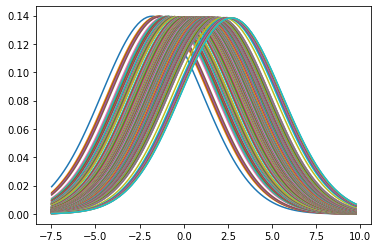

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
for i in range(len(sorted_mu)):
    mu = sorted_mu[i][1]
    variance = sorted_sigma[i][1]
    sigma = math.sqrt(variance)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [30]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

In [32]:
stats.norm.pdf(x, mu, sigma)

array([0.00154329, 0.00184762, 0.00220385, 0.00261912, 0.00310124,
       0.00365864, 0.0043004 , 0.0050362 , 0.00587626, 0.00683132,
       0.00791248, 0.00913116, 0.01049889, 0.01202724, 0.01372757,
       0.01561082, 0.01768734, 0.01996661, 0.02245696, 0.02516531,
       0.0280969 , 0.03125499, 0.03464058, 0.03825213, 0.04208535,
       0.04613293, 0.05038439, 0.05482589, 0.05944019, 0.06420657,
       0.06910088, 0.07409561, 0.07916007, 0.08426062, 0.08936098,
       0.09442261, 0.09940514, 0.10426691, 0.10896549, 0.11345829,
       0.1177032 , 0.12165924, 0.12528721, 0.12855033, 0.13141484,
       0.13385063, 0.13583174, 0.13733678, 0.1383494 , 0.1388585 ,
       0.1388585 , 0.1383494 , 0.13733678, 0.13583174, 0.13385063,
       0.13141484, 0.12855033, 0.12528721, 0.12165924, 0.1177032 ,
       0.11345829, 0.10896549, 0.10426691, 0.09940514, 0.09442261,
       0.08936098, 0.08426062, 0.07916007, 0.07409561, 0.06910088,
       0.06420657, 0.05944019, 0.05482589, 0.05038439, 0.04613

In [92]:
n_of_attributes = 4 + 3 + 3
n_of_values = 4

In [100]:
def skill_to_parm(TrueSkillObject):
    parms = []
    for i in TrueSkillObject.learners.keys():
        parms.append([TrueSkillObject.learners[i].mu,TrueSkillObject.learners[i].sigma])
    return parms

def parm_to_skill(parms):
    skill = TrueSkill_classifier()
    for i in range(len(parms)):
        skill.learners[i] = t.Rating(parms[i][0],parms[i][1])
    return skill

In [101]:
skill_to_parm(learner)

[[1.1363856222474222, 8.246627286984758],
 [-0.12462727056105051, 8.247884322966403],
 [1.0211722393490061, 8.251798451455963],
 [0.7935838471923997, 8.173909508458165],
 [0.8458225433284366, 8.263803539315136],
 [2.3886798105796143, 8.213849004672937],
 [1.8940298900427277, 8.267620278003307],
 [0.4292933503574946, 8.224890320312296],
 [1.5414275334248297, 8.244487859280706],
 [0.08950123806928136, 8.24416917605372],
 [1.7468822668928357, 8.27900595830752],
 [1.6838830886620173, 8.230332683961416],
 [-0.5264234072517853, 8.262507949338996],
 [-0.7588935674284012, 8.261659924837017],
 [0.41503116242982724, 8.227050548014471],
 [0.9254550476072707, 8.26282883606279],
 [1.9648255046293996, 8.227954934407725],
 [0.41528465568865824, 8.225730542163534],
 [-0.013702443476577179, 8.247047440198003],
 [0.9794322701253667, 8.249786243720282],
 [1.1592430584253421, 8.208355654989784],
 [2.0020368691727946, 8.26646722257691],
 [0.9310152402277166, 8.301961738957111],
 [1.3132374159847935, 8.2456

In [102]:
np.random.normal(mu, sigma, 1)

array([2.84283851])

In [103]:
def generate_users(N):
    users = {}
    for i in range(N):
        users['AutoGenerated{}'.format(i)] = [[np.random.normal(0, 0.5, 1)[0],np.random.normal(6,0.5,1)[0]] 
                                              for i in range(n_of_attributes*n_of_values)]
    return users

In [1]:
import GenerateUsers as G

In [2]:
G.generate_users(100)

{'AutoGenerated0': [[-0.12007521645757124, 5.9715468742041535],
  [-0.37678106032504466, 5.434705030728268],
  [0.3664995118048387, 6.100192203438392],
  [-0.036722355538125556, 4.745219359741355],
  [0.44786222376755763, 6.161700872391073],
  [-0.4820144370881636, 6.163810680724691],
  [0.31760761068109494, 6.972859546313791],
  [0.45389717475706437, 6.145802622721839],
  [-0.1382653837704123, 6.06349320145162],
  [-0.3947964785066796, 6.236509457258721],
  [-0.13528999354679352, 6.551766865912127],
  [0.0711997776467901, 5.573093028188051],
  [-0.41203626249513764, 5.886887346288831],
  [-0.1291001359301512, 5.120788031554293],
  [0.3746513226806113, 6.138625660503094],
  [-0.15172984872829923, 5.598010284068225],
  [0.39954894170462013, 6.119615920350602],
  [1.0789729149301015, 5.638410888781101],
  [-0.3602570031316364, 6.630589436138916],
  [0.029153791727365295, 6.734254769386397],
  [0.385010001557218, 5.137682248121183],
  [0.7854378866578354, 5.828137975297428],
  [-0.5331644